                           Text Minining for Customer satisfaction monitoring 

                                         Project Description

In this project we will build a model to estimate probability that a review showing the customer satisfaction.

Target Variable:    
Target is a binary variable that shows whether a review corresponds to good review/is_satisfied(1)or bad review/unsatisfied(0).

Target population:This model can be used on social media posts and customer reviews.  

output:
The probability if a textual review corresponds to a good review (the customer is satisfied).

Strategy:
get a deeper insight into reviews to make data-led decisions of improving customer experience faster   


The reviews overall ratings in feature "Score" can range from worst 1/5 to best 5/5.
In order to simplify the problem we will split those into two categories:

Good reviews have overall ratings >= 4
Bad reviews have overall ratings < 4


The challenge here is to be able to predict this information using only the raw textual data from the review.
Technique: Sentiment analysis is part of the Natural Language Processing (NLP) techniques that consists in extracting emotions related to some raw texts.


Let’s get it started!


                                            Data Exploration

In [1]:
import pandas as pd
import numpy as npsdaq

 Data : Sample data is from AMAZON(reviews sent to amazon.com website)
 Data Collection: Data was obtained from https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews
 Total Records: 568454,Total Columns: 10


In [2]:
data=pd.read_excel("C:/Users/reyha/Desktop/MLProject/Reviews.xlsx")

In [3]:
data.shape

(568454, 10)

                                          Preliminary feature exclusion

Exclude features that do not make sense or can not be used. For example, some features such as Gender can not be used in a Credit Risk model (fair lending practices).Here, we will not used HelpfulnessNumerator and HelpfulnessDenominator that will delete them and as we use a small subsample of features, we keep the rest 8 features. In an actual project, more features would have been selected.

ID would be used for data merge. Text and Score will be used to define dependent variable. The rest of the variables will be used as independent variables.

In [4]:
data.tail(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


 Check data types - objects imply non-numeric
Note that sometimes numeric columns appear as Object, because of few non-numeric observations. Such as a character that may represent a special value.

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(data.dtypes)

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


In [6]:
final_data = data[["Id", "Score","Text"]].copy()

In [7]:
# check the data frequently
final_data.tail(5)

,Id,Score,Text
568449,568450,5,Great for sesame chicken..this is a good if no...
568450,568451,2,I'm disappointed with the flavor. The chocolat...
568451,568452,5,"These stars are small, so you can give 10-15 o..."
568452,568453,5,These are the BEST treats for training and rew...
568453,568454,5,"I am very satisfied ,product is as advertised,..."


In [8]:
#features1 = data[["Id", 'ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator', "Score","Time",'Summary','Text']].copy


                                                   One-Hot Encoding        

Define target variable based on "score" column. 
We define everyone who gave a score of more than 3( 4 or 5) as satisfied (1) ,and less as unsatisfied (0).

In [9]:
# create the label
final_data["is_satisfied"] = final_data["Score"].apply(lambda x: 1 if x >= 4 else 0)


<AxesSubplot:>

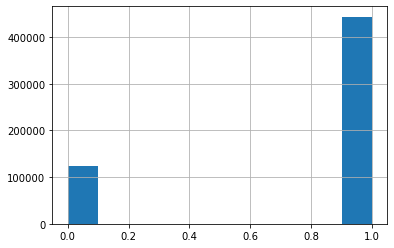

In [10]:
final_data["is_satisfied"] = final_data["is_satisfied"].astype(int)
final_data["is_satisfied"].hist()

In [11]:
# select only relevant columns
final_data = final_data[["Id","Text", "is_satisfied"]]
final_data.head()

,Id,Text,is_satisfied
0,1,I have bought several of the Vitality canned d...,1
1,2,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,This is a confection that has been around a fe...,1
3,4,If you are looking for the secret ingredient i...,0
4,5,Great taffy at a great price. There was a wid...,1


In [12]:
# check response rate of whole population:78%
final_data[["is_satisfied", "Id"]].groupby(["is_satisfied"]).count()

,Id
is_satisfied,
0,124677
1,443777


In [13]:
### We sample the data to speed up computations:                  
final_data = final_data.sample(frac = 0.05, replace = False, random_state=42)


                                 cleaning the text data with various operations:
 To clean textual data, we call our custom ‘clean_text’ function that performs several transformations:
 lower the text
 tokenize the text (split the text into words) and remove the punctuation
 remove useless words that contain numbers
 remove useless stop words like ‘the’, ‘a’ ,’this’ etc.
 Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun,verb etc.using the WordNet  lexical database
 lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)
 return the wordnet object value corresponding to the POS tag

In [14]:
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords'),nltk.download('averaged_perceptron_tagger'),nltk.download('wordnet'),nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reyha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\reyha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\reyha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\reyha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(True, True, True, True)

In [15]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [17]:
def clean_txt(txt):
    # lower text
    txt = txt.lower()
    # tokenize text and remove puncutation
    txt = [word.strip(string.punctuation) for word in txt.split(" ")]
    # remove words that contain numbers
    txt = [word for word in txt if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    txt = [x for x in txt if x not in stop]
    # remove empty tokens
    txt = [t for t in txt if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(txt)
    # lemmatize text
    txt = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    txt = [t for t in txt if len(t) > 1]
    # join all
    txt = " ".join(txt)
    return(txt)

In [18]:
### clean text data
final_data["Text_clean"] = final_data["Text"].apply(lambda x: clean_txt(x))

In [19]:
# check the data frequently
final_data.tail(20)

,Id,Text,is_satisfied,Text_clean
473886,473887,I cannot find these delicious eggs down here i...,1,cannot find delicious egg virgina decide check...
274836,274837,"The ""Atkins Fudge Brownie Advantage Bars"" are ...",1,atkins fudge brownie advantage bar great taste...
27677,27678,I used two of the 5 gram pouches for a gallon ...,1,use two gram pouch gallon milk one sleeve tota...
566150,566151,I can't get enough PB2. I put it in my smooth...,1,can't get enough put smoothy almost every morn...
551400,551401,This energy drink tastes good and doesn't give...,1,energy drink taste good give jitter sugar free...
232955,232956,I enjoy so much the caviar I get from the sala...,1,enjoy much caviar get salad bar go chart house...
103393,103394,"A little drier tasting than beef jerky sticks,...",1,little dry taste beef jerky stick also salty s...
11031,11032,"Great before, during, and after a workout. Gre...",1,great workout great natural electrolyte high p...
510629,510630,This tastes much better than any of the normal...,1,taste much well normal stuff buy local grocery...
190636,190637,It took 2 kits to get a full garden. Only 2 ...,0,take kit get full garden seed grow first kit w...


In [20]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
final_data["sentiments"] = final_data["Text"].apply(lambda x: sid.polarity_scores(x))
final_data = pd.concat([final_data.drop(['sentiments'], axis=1), final_data['sentiments'].apply(pd.Series)], axis=1)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\reyha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# check the data frequently
final_data.tail(5)

,Id,Text,is_satisfied,Text_clean,neg,neu,pos,compound
109311,109312,I ordered the Grade B Hidden Springs Syrup -- ...,1,order grade hidden spring syrup grade favorite...,0.000,0.663,0.337,0.9464
492186,492187,I must say I cannot agree with the other revie...,1,must say cannot agree reviewer thought grape f...,0.194,0.673,0.133,-0.5283
254260,254261,I was looking for a way to avoid the HFCS in s...,1,look way avoid hfc soda without give entirely ...,0.032,0.888,0.080,0.8103
568395,568396,My mom-in-law had rec'd 1 box of these in a gi...,1,mom-in-law rec'd box gift box find found enjoy...,0.038,0.765,0.197,0.9168
209331,209332,"Having spent time in Morocco, I had the chance...",1,spent time morocco chance sample authentic tur...,0.056,0.799,0.144,0.8013


In [22]:
# add number of characters column
final_data["nb_chars"] = final_data["Text"].apply(lambda x: len(x))

# add number of words column
final_data["nb_words"] = final_data["Text"].apply(lambda x: len(x.split(" ")))

In [23]:
# check the data frequently
final_data.tail(5)

,Id,Text,is_satisfied,Text_clean,neg,neu,pos,compound,nb_chars,nb_words
109311,109312,I ordered the Grade B Hidden Springs Syrup -- ...,1,order grade hidden spring syrup grade favorite...,0.000,0.663,0.337,0.9464,297,54
492186,492187,I must say I cannot agree with the other revie...,1,must say cannot agree reviewer thought grape f...,0.194,0.673,0.133,-0.5283,469,80
254260,254261,I was looking for a way to avoid the HFCS in s...,1,look way avoid hfc soda without give entirely ...,0.032,0.888,0.080,0.8103,697,144
568395,568396,My mom-in-law had rec'd 1 box of these in a gi...,1,mom-in-law rec'd box gift box find found enjoy...,0.038,0.765,0.197,0.9168,351,73
209331,209332,"Having spent time in Morocco, I had the chance...",1,spent time morocco chance sample authentic tur...,0.056,0.799,0.144,0.8013,435,79


                                                Neural Network 
Extracting vector representations for every review using shallow neural networks:

In [24]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_data["Text_clean"].apply(lambda x: x.split(" ")))]

In [25]:
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [26]:
# transform each document into a vector data
doc2vec_df = final_data["Text_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
final_data = pd.concat([final_data, doc2vec_df], axis=1)

In [27]:
# check the data frequently
final_data.tail(5)

,Id,Text,is_satisfied,Text_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
109311,109312,I ordered the Grade B Hidden Springs Syrup -- ...,1,order grade hidden spring syrup grade favorite...,0.000,0.663,0.337,0.9464,297,54,-0.171889,0.686100,-0.077288,0.471563,0.067078
492186,492187,I must say I cannot agree with the other revie...,1,must say cannot agree reviewer thought grape f...,0.194,0.673,0.133,-0.5283,469,80,-0.155476,0.273000,0.420285,-0.258440,-0.397646
254260,254261,I was looking for a way to avoid the HFCS in s...,1,look way avoid hfc soda without give entirely ...,0.032,0.888,0.080,0.8103,697,144,-0.330065,0.087969,1.449520,0.361005,0.527750
568395,568396,My mom-in-law had rec'd 1 box of these in a gi...,1,mom-in-law rec'd box gift box find found enjoy...,0.038,0.765,0.197,0.9168,351,73,-0.273782,0.096917,0.393868,-0.113876,0.272825
209331,209332,"Having spent time in Morocco, I had the chance...",1,spent time morocco chance sample authentic tur...,0.056,0.799,0.144,0.8013,435,79,0.053479,0.400347,0.456332,-0.335111,-0.122981


In [28]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer


In [29]:
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(final_data["Text_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = final_data .index
final_data  = pd.concat([final_data , tfidf_df], axis=1)

C:\Users\reyha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
# check the data frequently
final_data.tail(5)

,Id,Text,is_satisfied,Text_clean,neg,neu,pos,compound,nb_chars,nb_words,...,word_zinger,word_zip,word_ziploc,word_ziplock,word_zipper,word_ziwipeak,word_zucchini,word_zuke,word_zukes,word_â½
109311,109312,I ordered the Grade B Hidden Springs Syrup -- ...,1,order grade hidden spring syrup grade favorite...,0.000,0.663,0.337,0.9464,297,54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492186,492187,I must say I cannot agree with the other revie...,1,must say cannot agree reviewer thought grape f...,0.194,0.673,0.133,-0.5283,469,80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254260,254261,I was looking for a way to avoid the HFCS in s...,1,look way avoid hfc soda without give entirely ...,0.032,0.888,0.080,0.8103,697,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568395,568396,My mom-in-law had rec'd 1 box of these in a gi...,1,mom-in-law rec'd box gift box find found enjoy...,0.038,0.765,0.197,0.9168,351,73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209331,209332,"Having spent time in Morocco, I had the chance...",1,spent time morocco chance sample authentic tur...,0.056,0.799,0.144,0.8013,435,79,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
!pip install wordcloud

In [32]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

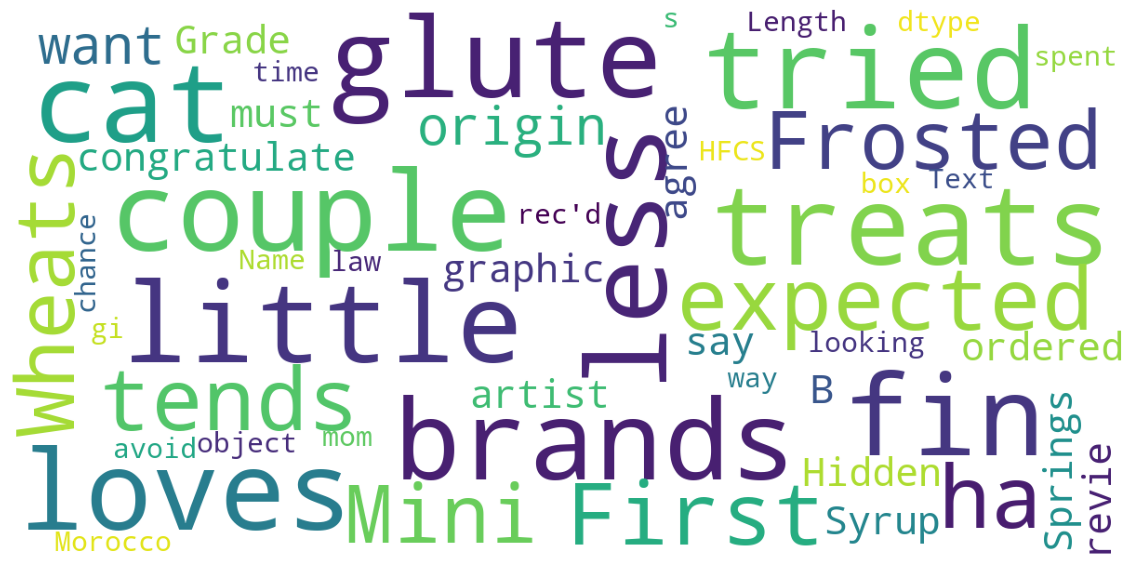

In [33]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(final_data["Text"])

In [34]:
# highest positive sentiment reviews (with more than 5 words)
final_data[final_data["nb_words"] >= 5].sort_values("pos", ascending = False)[["Text", "pos"]].head(5)


,Text,pos
30645,I have tried many gluten free brownies these ...,0.673
272935,Emeril's Big Easy Bold has incredibly great fl...,0.663
145985,We now enjoy better espresso at home than at t...,0.627
461888,Excellent flavor. Easy to make. Everybody like...,0.624
174560,What a great deal on a favorite treat. I love ...,0.622


In [35]:
# lowest negative sentiment reviews (with more than 5 words)
final_data[final_data["nb_words"] >= 5].sort_values("neg", ascending = False)[["Text", "neg"]].head(5)


,Text,neg
31777,"This stuff is the most vile, disgusting stuff ...",0.533
130741,"Bad tasting coffee, no aroma/baked, very dry, ...",0.464
192524,"I love bold coffee, but this is seriously over...",0.440
538581,"This was the worst coffee<a href=""http://www.a...",0.412
240598,Just plain nasty. It's like all waste product....,0.409


C:\Users\reyha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\reyha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


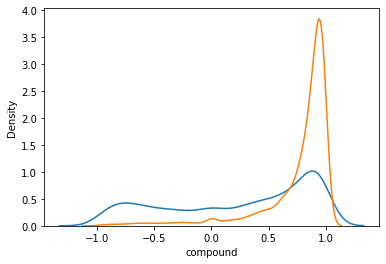

In [36]:
# plot sentiment distribution for positive and negative reviews: 

import seaborn as sns

for x in [0, 1]:
    subset = final_data[final_data['is_satisfied'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Bad reviews"
    else:
        label = "Good reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

                                               Train/Test split
                                               
split the data into train and test:
one to train our model
one to test (assess model's performances) 

In [41]:

from sklearn.model_selection import train_test_split
 
label = "is_satisfied"
ignore_cols = [label,"Text", "Text_clean"]                           #take out label, for check train/test are unbiased
features = [c for c in final_data.columns if c not in ignore_cols]

X_train, X_test, Y_train, Y_test = train_test_split(final_data[features], final_data[label], test_size = 0.30, random_state = 42)


      compare test and train samples to make sure they are not fundamentally different.
      
If so, we will get high variance even with a non-overfitted model.Here we compare Response rate in both samples:

In [38]:
# Response rate of the 0.1 fraction of whole population:77.99%
final_data[["is_satisfied", "Id"]].groupby(["is_satisfied"]).count()


,Id
is_satisfied,
0,6255
1,22168


In [39]:
# Response rate of Train sample: 78.05% 
X_train[["is_satisfied", "Id"]].groupby(["is_satisfied"]).count()

,Id
is_satisfied,
0,4367
1,15529


In [40]:
# Response rate of Test sample: 77.86%  
X_test[["is_satisfied", "Id"]].groupby(["is_satisfied"]).count()


,Id
is_satisfied,
0,1888
1,6639


                                                 Feature selection
                                                 
                                                 

In [43]:
# train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_for_feature_selection =rf.fit(X_train, Y_train)

In [44]:
D


,feature,importance
4,compound,0.053800
3,pos,0.044450
1,neg,0.035949
2,neu,0.017708
2932,word_love,0.008662
2222,word_great,0.007937
5,nb_chars,0.007573
11,doc2vec_vector_4,0.007233
9,doc2vec_vector_2,0.006963
8,doc2vec_vector_1,0.006896


In [46]:
# choose features with Feature Importance of higher than 1%                     # Don't do if using below RF 
final_features = feature_importances_df["feature"][feature_importances_df.importance > 0.01]

X_train = X_train[final_features]
X_test = X_test[final_features]



In [47]:
X_train.shape

(19896, 4)

In [48]:
X_test.shape

(8527, 4)

                                   Evaluate the performance of Random Forest model: 
 The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of our classifier.
 The higher the curve is above the diagonal baseline, the better the predictions.

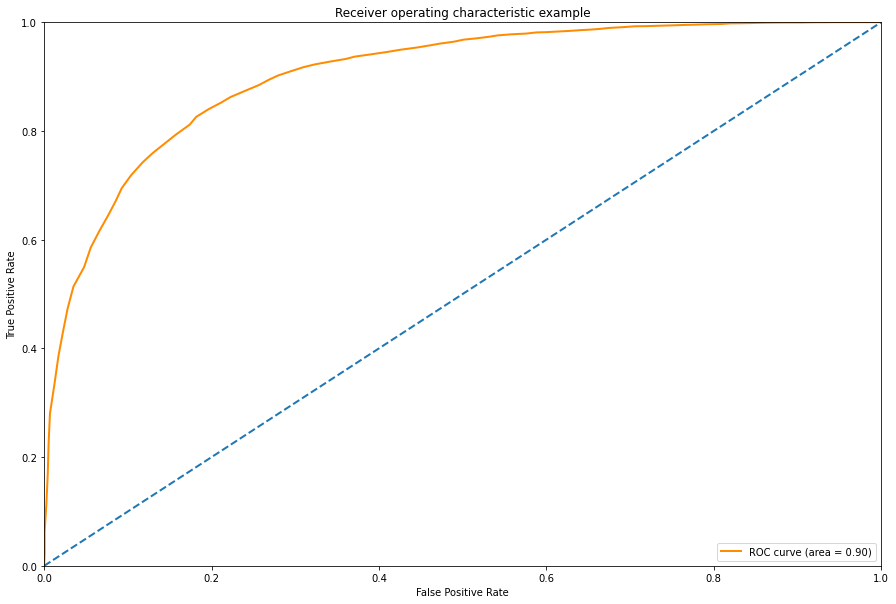

In [45]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

We can see that the precision decreases when we increase the recall. 
This shows us that we have to choose a prediction thresold adapted to our needs.
If our goal is to have a high recall, we should set a low prediction thresold that will allow us to detect most of the observations of the positive class, but with a low precision. 
On the contrary, if we want to be really confident about our predictions but don’t mind about not finding all the positive observations,we should set a high thresold that will get us a high precision and a low recall.

In [49]:
!pip3 install funcsigs
from funcsigs import signature
from sklearn.metrics import average_precision_score, precision_recall_curve

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.97')

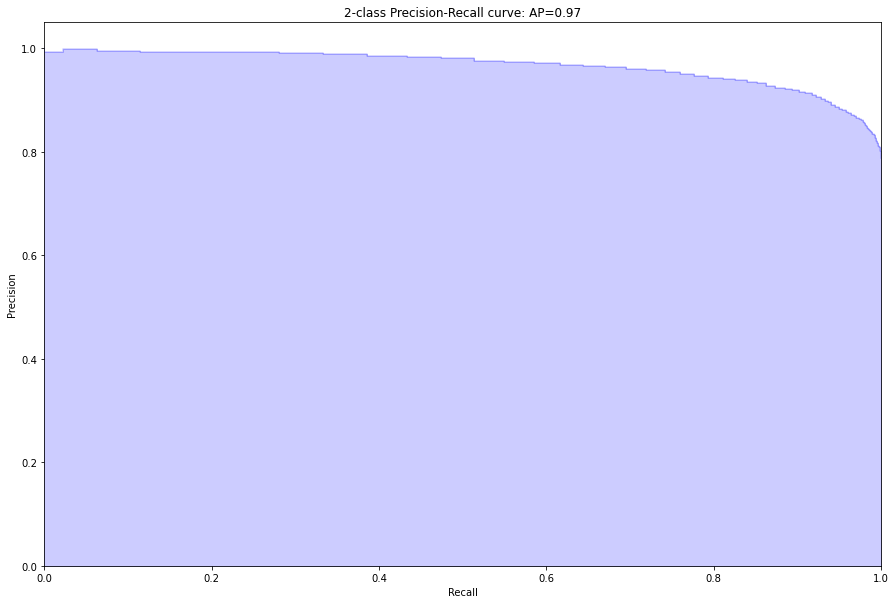

In [50]:
# PR curve

average_precision = average_precision_score(Y_test, y_pred)

precision, recall, _ = precision_recall_curve(Y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

                                                Build XGBoost model

In [51]:
!pip install xgboost
import xgboost as xgb
xgb_instance = xgb.XGBClassifier(n_estimators=100, random_state=42) 



                                       Grid Search and Bias/Variance analysis

In [52]:
# Here we do grid search only on #trees, and look at the AUC as performance metric.
from sklearn.metrics import roc_auc_score
table = pd.DataFrame(columns = ["Num Trees", "Learning Rate","Tree depth", "AUC Train", "AUC Test"])
row = 0
for num_trees in [10, 20, 50, 100]:
  for LR in [0.01, 0.1, 0.05]:
    for tree_depth in [2,4]:
       xgb_instance = xgb.XGBClassifier(n_estimators=num_trees, learning_rate = LR, max_depth =tree_depth)
       model = xgb_instance.fit(X_train, Y_train)
       table.loc[row,"Num Trees"] = num_trees
       table.loc[row,"Learning Rate"] = LR
       table.loc[row,"Tree depth"] = tree_depth
       table.loc[row,"AUC Train"] = roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])  
       table.loc[row,"AUC Test"] = roc_auc_score(Y_test, model.predict_proba(X_test)[:,1])  
       row = row + 1
table



,Num Trees,Learning Rate,Tree depth,AUC Train,AUC Test
0,10,0.01,2,0.774334,0.77422
1,10,0.01,4,0.812049,0.807537
2,10,0.1,2,0.808189,0.808907
3,10,0.1,4,0.81806,0.814826
4,10,0.05,2,0.793633,0.796606
5,10,0.05,4,0.814948,0.810902
6,20,0.01,2,0.782345,0.783807
7,20,0.01,4,0.813586,0.809008
8,20,0.1,2,0.813894,0.813231
9,20,0.1,4,0.821627,0.816712


                                       Shap Value for our best XGBoost model

In [53]:
import xgboost as xgb


xgb_cl = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [54]:
xgb_cl.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [55]:
import shap
Xd = xgb.DMatrix(X_train, label=Y_train)
explainer = shap.TreeExplainer(xgb_cl)
shap_values = explainer.shap_values(Xd)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


A variable importance plot lists the most significant variables in descending order.

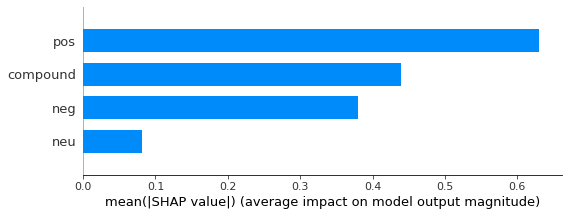

In [56]:

shap.summary_plot(shap_values, X_train, plot_type="bar")

The SHAP value plot can show the positive and negative relationships of the predictors with the target variable.

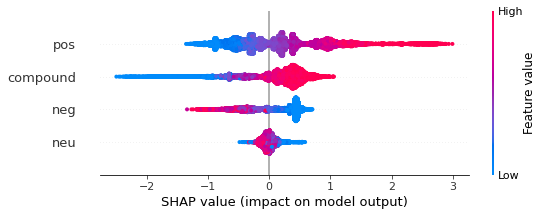

In [57]:
shap.summary_plot(shap_values, X_train)

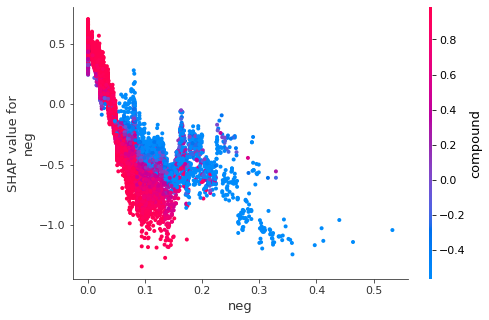

In [58]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)

shap.dependence_plot(2, shap_values, X_train)

                                 Individual SHAP Value Plot for an observation

In [59]:
import numpy as np
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

In [60]:
# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,compound,pos,neg,neu,predict
385583,0.9224,0.203,0.000,0.797,1
516699,0.9631,0.215,0.041,0.744,1
210112,-0.6670,0.090,0.118,0.792,0
437353,0.1513,0.055,0.042,0.903,1
410717,0.6492,0.155,0.000,0.845,1
53313,0.9965,0.168,0.050,0.782,1
120770,0.8265,0.172,0.000,0.828,1


In [61]:
shap.initjs()

In [62]:
# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)   
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])  #  the matrix of feature values  
                       #the base value (the average of the model output over the training data X_train) 
    return(p)

In [63]:
shap_plot(0)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [ ]:
############################################################################################https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

In [ ]:
######https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [ ]:
#https://analyticsindiamag.com/a-guide-to-explaining-feature-importance-in-neural-networks-using-shap/#:~:text=SHAP%20values%20%28SHapley%20Additive%20exPlanations%29%20is%20an%20awesome,you%20which%20feature%20is%20important%20for%20making%20predictions.

                                            Building a Neural Network model


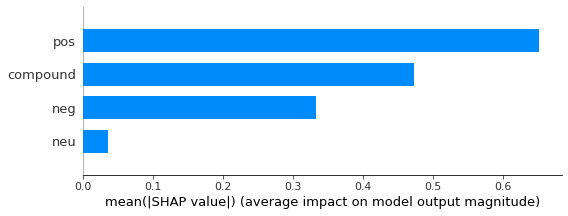

In [64]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [65]:
!pip install -U tensorflow


In [66]:
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense

In [67]:
# create a Sequential object, as a sequence of layers. 
classifier = Sequential()

classifier.add (Dense (units=2, kernel_initializer='glorot_uniform',
                    activation = 'tanh'))
# add the second hidden layer
classifier.add (Dense (units=2, kernel_initializer='glorot_uniform',
                    activation = 'tanh'))



In [68]:
# add the third hidden layer
classifier.add (Dense (units=2, kernel_initializer='glorot_uniform',
                    activation = 'tanh'))


In [69]:
# add the output layer
classifier.add (Dense (units=1, kernel_initializer='glorot_uniform',
                    activation = 'sigmoid'))

# add additional parameters
classifier.compile(optimizer = 'adam' , loss = 'binary_crossentropy',  
                   metrics = ['accuracy'] )   

In [70]:
classifier.fit(X_train, Y_train,batch_size=1000,epochs=20)
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train, classifier.predict(X_train))

Epoch 1/20
20/20 [==============================] - 1s 2ms/step - loss: 0.7757 - accuracy: 0.1817
Epoch 2/20
20/20 [==============================] - 0s 1ms/step - loss: 0.7342 - accuracy: 0.1887
Epoch 3/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6991 - accuracy: 0.4855
Epoch 4/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6699 - accuracy: 0.7805
Epoch 5/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.7805
Epoch 6/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6226 - accuracy: 0.7805
Epoch 7/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6025 - accuracy: 0.7805
Epoch 8/20
20/20 [==============================] - 0s 1ms/step - loss: 0.5841 - accuracy: 0.7805
Epoch 9/20
20/20 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7805
Epoch 10/20
20/20 [==============================] - 0s 1ms/step - loss: 0.5541 - accuracy: 0.7805
Epoch 11/20
20/20 [

0.8019292313517646

In [71]:
# train the model
classifier.fit(X_train, Y_train,batch_size=1000,epochs=20)

from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train, classifier.predict(X_train))


Epoch 1/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4852 - accuracy: 0.7805
Epoch 2/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4802 - accuracy: 0.7805
Epoch 3/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4750 - accuracy: 0.7806
Epoch 4/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4699 - accuracy: 0.7858
Epoch 5/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.8033
Epoch 6/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4607 - accuracy: 0.8118
Epoch 7/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4566 - accuracy: 0.8147
Epoch 8/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4531 - accuracy: 0.8167
Epoch 9/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4500 - accuracy: 0.8170
Epoch 10/20
20/20 [==============================] - 0s 1ms/step - loss: 0.4474 - accuracy: 0.8176
Epoch 11/20
20/20 [

0.7954531851389004

In [72]:
roc_auc_score(Y_test, classifier.predict(X_test))

267/267 [==============================] - 0s 904us/step


0.7998044107622906

             Building a model with 10-fold cross validation with params of our best Neural Network model
                      

In [73]:
# Load libraries
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np


In [74]:
acc_per_fold = []
loss_per_fold = []

In [75]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

In [76]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)


In [77]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    # Define the model architecture
    classifier = Sequential()
    classifier.add (Dense (units=2, kernel_initializer='glorot_uniform',
                    activation = 'tanh'))
    # add the second hidden layer
    classifier.add (Dense (units=2, kernel_initializer='glorot_uniform',
                    activation = 'tanh'))
    # add the third hidden layer
    classifier.add (Dense (units=2, kernel_initializer='glorot_uniform',
                    activation = 'tanh'))
    # add the output layer
    classifier.add (Dense (units=1, kernel_initializer='glorot_uniform',
                    activation = 'sigmoid'))
    
    # compile the model
    classifier.compile(optimizer = 'adam' , loss = 'binary_crossentropy',  
                   metrics = ['accuracy'] )
    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = classifier.fit(inputs[train], targets[train],
              epochs=20,
              batch_size=1000,
              verbose=0)
    
    # Generate generalization metrics
    scores = classifier.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1
        

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4372963011264801; accuracy of 82.34259486198425%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.5292742848396301; accuracy of 78.29757332801819%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.4676071107387543; accuracy of 80.23214936256409%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.4178127944469452; accuracy of 82.5123131275177%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.4321897327899933; accuracy of 81.52709603309631%
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.457257

                                        Final Model Selection

In [78]:
# define Dense matrix for model
xgb_instance = xgb.XGBClassifier(n_estimators=100, learning_rate = 0.1,max_depth=4)
final_model = xgb_instance.fit(X_train, Y_train)

In [79]:
# Rank Ordering
perf_train_data = pd.DataFrame({"Actual": Y_train, "Prediction": final_model.predict_proba(X_train)[:,1]})
quantiles = list(set(perf_train_data.Prediction.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
quantiles.sort()
quantiles.insert(0,0)
quantiles.insert(len(quantiles),1)

perf_train_data["Score Bins"] = pd.cut(perf_train_data["Prediction"], quantiles)
stat = perf_train_data.groupby("Score Bins")["Actual"].agg(["sum", "count"])
stat["Response Rate"] = stat["sum"] / stat["count"]
stat

,sum,count,Response Rate
Score Bins,,,
"(0.0, 0.472]",558,1990,0.280402
"(0.472, 0.624]",1097,1990,0.551256
"(0.624, 0.724]",1327,1989,0.667169
"(0.724, 0.798]",1544,1995,0.773935
"(0.798, 0.853]",1632,1984,0.822581
"(0.853, 0.895]",1781,2024,0.879941
"(0.895, 0.926]",1793,1956,0.916667
"(0.926, 0.956]",1911,2007,0.952167
"(0.956, 0.97]",1917,1974,0.971125


In [80]:
stat["Response Rate"] = stat["Response Rate"].astype(int)

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

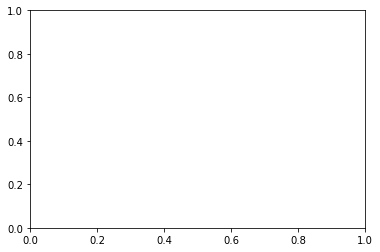

In [81]:
import matplotlib.pyplot as plt
plt.plot(stat["Response Rate"])

                                        Building Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

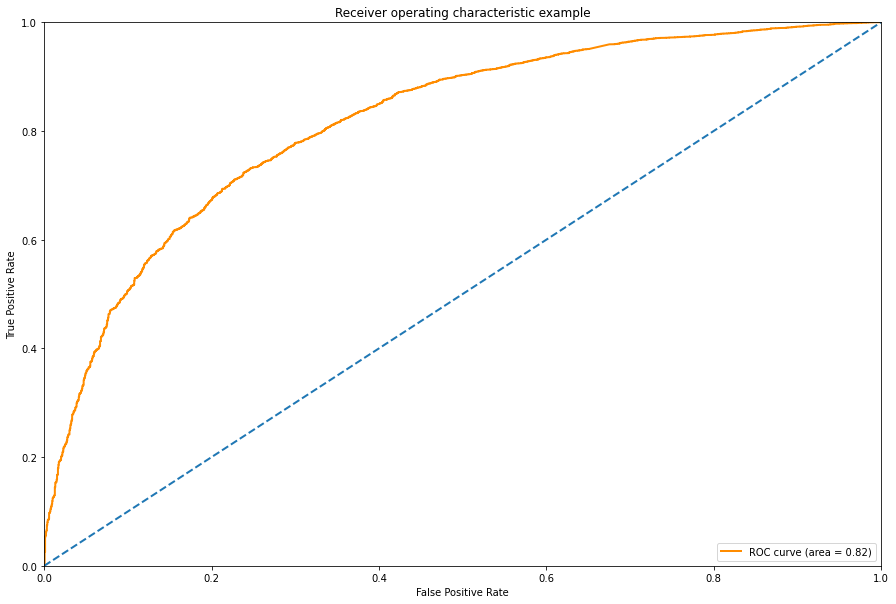

In [84]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in clf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

                                           Training decision tree classifier

In [85]:

from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=0)
dt_classifier.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=0)

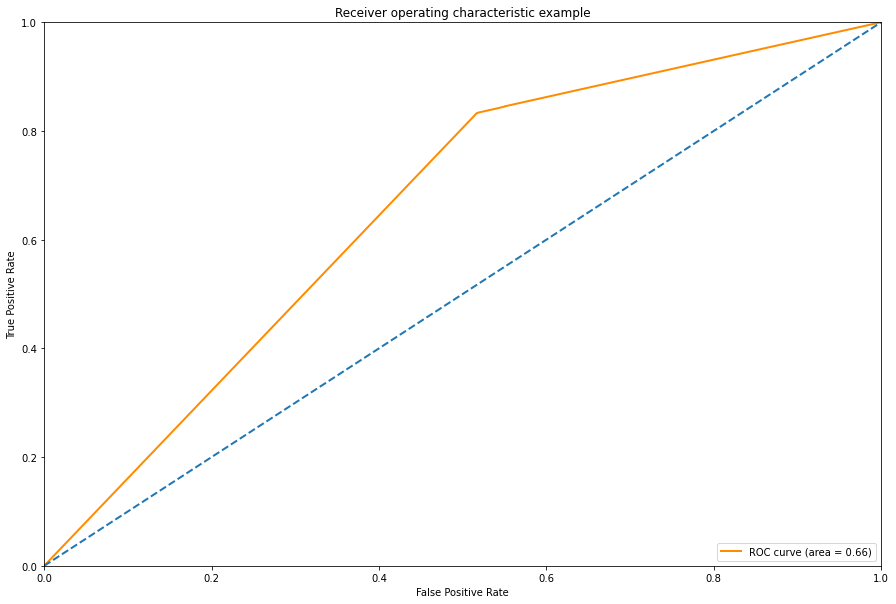

In [86]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in dt_classifier.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [87]:
from sklearn.model_selection import GridSearchCV

In [88]:
params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
}

dt_best_classifier = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

dt_best_classifier.fit(X_train, Y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=5,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 6, 8, 10],
                         'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6,
                                          0.8],
                         'splitter': ['best', 'random']},
             verbose=1)

In [89]:
from sklearn import tree
text_representation = tree.export_text(dt_best_classifier.best_estimator_)
print(text_representation)


|--- feature_0 <= 0.49
|   |--- feature_0 <= -0.27
|   |   |--- feature_0 <= -0.66
|   |   |   |--- feature_2 <= 0.23
|   |   |   |   |--- feature_3 <= 0.71
|   |   |   |   |   |--- feature_2 <= 0.23
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_2 >  0.23
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_3 >  0.71
|   |   |   |   |   |--- feature_2 <= 0.10
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_2 >  0.10
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  0.23
|   |   |   |   |--- feature_1 <= 0.08
|   |   |   |   |   |--- feature_0 <= -0.82
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  -0.82
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  0.08
|   |   |   |   |   |--- feature_0 <= -0.76
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  -0.76
|   |   |   |   |   |   |--- class: 0
|   |   |--- feature_0 >  -0.66
|   |  

In [90]:
X_train

,compound,pos,neg,neu
383129,0.9753,0.229,0.000,0.771
89716,0.9766,0.292,0.019,0.689
117315,-0.4767,0.000,0.119,0.881
509004,0.7964,0.234,0.062,0.704
517576,0.9770,0.213,0.062,0.725
...,...,...,...,...
35965,-0.8777,0.066,0.205,0.729
129490,0.7346,0.199,0.089,0.712
512131,0.9812,0.289,0.038,0.672
532156,0.8777,0.347,0.000,0.653


[Text(0.5, 0.875, 'X[0] <= 0.416\ngini = 0.343\nsamples = 19896\nvalue = [4367, 15529]'),
 Text(0.25, 0.625, 'X[0] <= -0.427\ngini = 0.491\nsamples = 3826\nvalue = [2170, 1656]'),
 Text(0.125, 0.375, 'X[0] <= -0.673\ngini = 0.366\nsamples = 1292\nvalue = [980, 312]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'X[0] <= -0.008\ngini = 0.498\nsamples = 2534\nvalue = [1190, 1344]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'X[1] <= 0.168\ngini = 0.236\nsamples = 16070\nvalue = [2197, 13873]'),
 Text(0.625, 0.375, 'X[2] <= 0.036\ngini = 0.371\nsamples = 5452\nvalue = [1339, 4113]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'X[2] <= 0.05\ngini = 0.149\nsamples = 10618\nvalue = [858, 9760]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

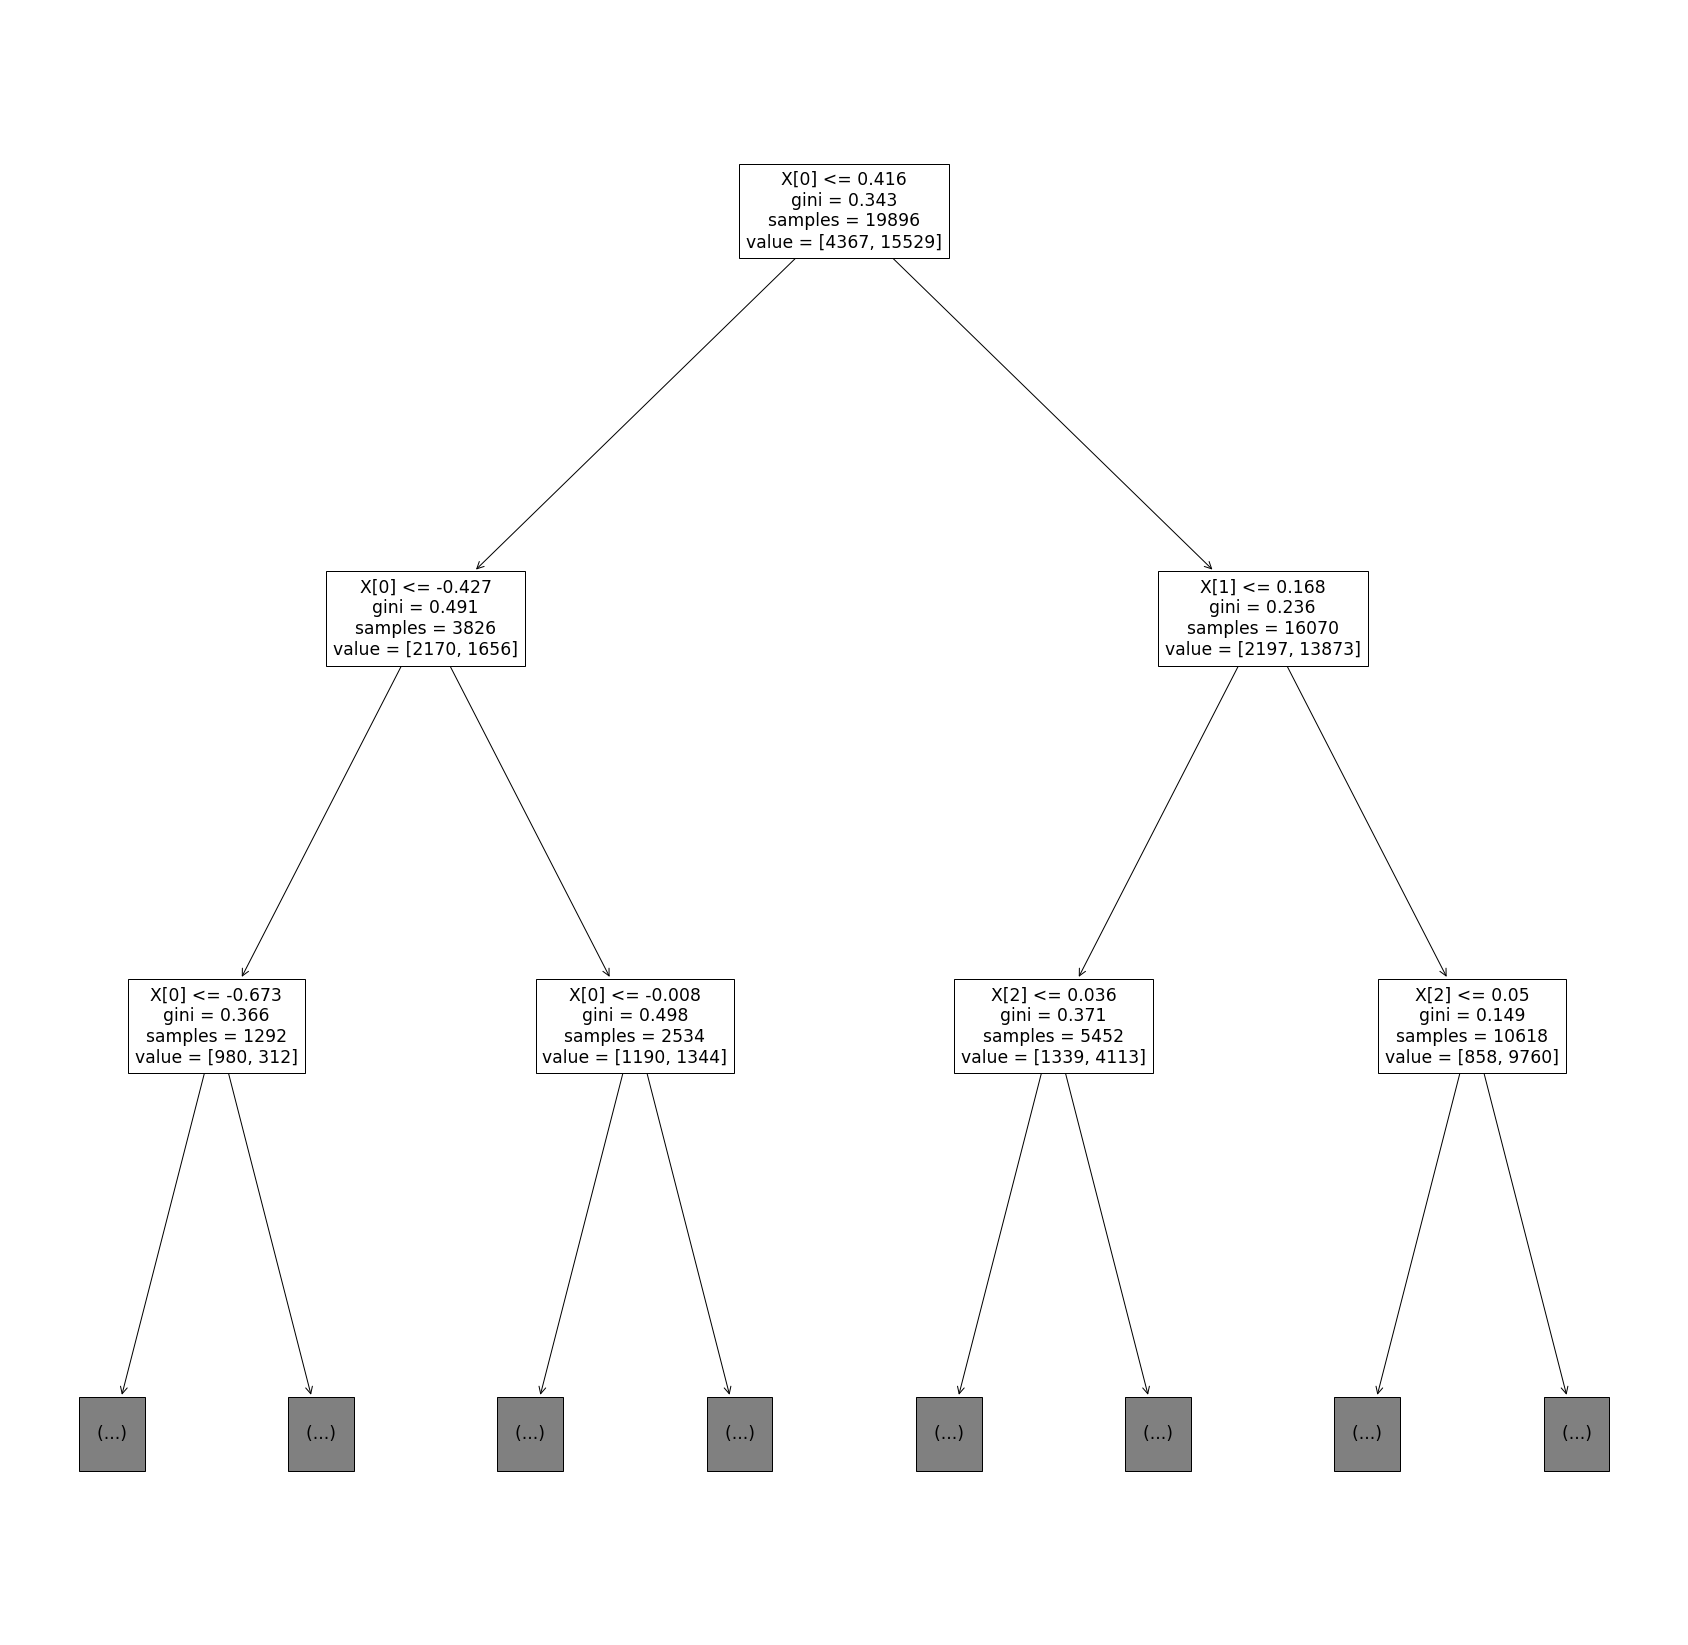

In [93]:

from sklearn.tree import plot_tree
feature_names = X_test.columns
target_names = Y_test.unique().tolist()
plt.figure(figsize=(30,30))

plot_tree(dt_classifier,max_depth=2)


In [94]:
ignore_cols1 = ["ProductId","ProfileName","Text", "Summary"]                         
features = [c for c in data.columns if c not in ignore_cols1]

#, UserId, ProfileName, Summary, Text

In [95]:

data["is_satisfied"] = np.where(data['Score'].astype(int)>3,1,0)

In [96]:
Y = data["is_satisfied"]
X =  data[['Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text']] 


In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [98]:
import xgboost as xgb

final_model = xgb.XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=4, random_state=42)
final_model.fit(X_train, Y_train)  


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:ProductId, UserId, ProfileName, Summary, Text

In [ ]:
!pip install shap
import shap

In [ ]:
e = shap.KernelExplainer(final_model, X_train)
shap_values = e.shap_values(X_test)


In [ ]:
importances = final_model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()